# AI for Executives: Demonstration of the Titanic Dataset

## Preliminaries

After loading the required Python libraries and packages, we read in the dataset and save it as "df". OpenML is an excellent source for Machine Learning datasets such as this one. 

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
df=pd.read_csv("phpMYEkMl.csv")

Source for the dataset: https://www.openml.org/d/40945

## Data Preparation: Missing Values

Take a first look at the dataset and check for missing values.

In [3]:
df.head(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48,0,0,19952,26.55,E12,S,3,?,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63,1,0,13502,77.9583,D7,S,10,?,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39,0,0,112050,0,A36,S,?,?,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53,2,0,11769,51.4792,C101,S,D,?,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71,0,0,PC 17609,49.5042,?,C,?,22,"Montevideo, Uruguay"


In [4]:
df.tail()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1304,3,0,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,?,C,?,328,?
1305,3,0,"Zabour, Miss. Thamine",female,?,1,0,2665,14.4542,?,C,?,?,?
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.225,?,C,?,304,?
1307,3,0,"Zakarian, Mr. Ortin",male,27,0,0,2670,7.225,?,C,?,?,?
1308,3,0,"Zimmerman, Mr. Leo",male,29,0,0,315082,7.875,?,S,?,?,?


In [5]:
df.isnull().sum()

pclass       0
survived     0
name         0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
cabin        0
embarked     0
boat         0
body         0
home.dest    0
dtype: int64

At first glance, it seems that there are no missing values. However, some missing values are "hidden": For instance, a question mark indicates that we don't know where the passenger boarded the Titanic. Let's remove these instances. 

In [6]:
df.embarked.value_counts()

S    914
C    270
Q    123
?      2
Name: embarked, dtype: int64

In [7]:
df=df[df["embarked"]!="?"]
df.embarked.value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

Similarly, let's also remove passengers whose age is unknown. Again, missing values hide behind question marks.

In [8]:
df=df[df["age"]!="?"]
df=df[df["fare"]!="?"]
df.shape

(1043, 14)

In [9]:
df.dtypes

pclass        int64
survived      int64
name         object
sex          object
age          object
sibsp         int64
parch         int64
ticket       object
fare         object
cabin        object
embarked     object
boat         object
body         object
home.dest    object
dtype: object

In [10]:
df=df.astype({"fare":float})

We check that we know for each passenger in the remaining dataset the class that they were traveling in.

In [11]:
df.pclass.value_counts()

3    500
1    282
2    261
Name: pclass, dtype: int64

Another variable indicates the number of family members with which a passenger was traveling. Let's visualize the distribution of this variable in a histogram.

(array([682., 280.,  36.,  16.,  22.,   6.,   0.,   0.,   1.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
 <a list of 9 Patch objects>)

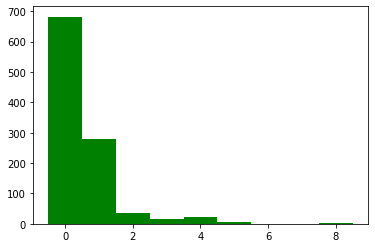

In [12]:
plt.hist(df.sibsp,color="green",bins=[x-0.5 for x in range(0,10)])

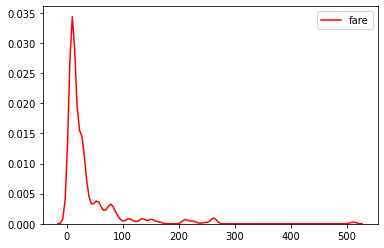

In [13]:
sns.kdeplot(df.fare,color="red")

## Data Preparation: Feature Engineering

Now restrict attention to a smaller set of columns. We create a new column which indicates whether a passenger's dead body is missing.

In [14]:
cols=["sex","pclass","age","embarked","survived","boat","body","fare","sibsp"]
df=df[cols]

In [15]:
df["missing_dead_body"]=np.where((df["survived"]==0) & (df["body"]=="?"), 1,0)
df.head()

,sex,pclass,age,embarked,survived,boat,body,fare,sibsp,missing_dead_body
0,female,1,29,S,1,2,?,211.3375,0,0
1,male,1,0.9167,S,1,11,?,151.5500,1,0
2,female,1,2,S,0,?,?,151.5500,1,1
3,male,1,30,S,0,?,135,151.5500,1,0
4,female,1,25,S,0,?,?,151.5500,1,1


In [16]:
df.missing_dead_body.value_counts()

0    544
1    499
Name: missing_dead_body, dtype: int64

Next, let's work on the age column. We want to distinguish three groups of passengers: Children (less than 16 years of age), adults (less than 60 years of age), and elderly people (60 years old or older).  

In [17]:
df["age"]=df["age"].astype(float)

def age_groups(entry):
    if entry<16.0:
        return "child"
    elif entry<60.0:
        return "adult"
    else:
        return "elderly"

df["age"]=df["age"].apply(age_groups)
df.head(10)

,sex,pclass,age,embarked,survived,boat,body,fare,sibsp,missing_dead_body
0,female,1,adult,S,1,2,?,211.3375,0,0
1,male,1,child,S,1,11,?,151.5500,1,0
2,female,1,child,S,0,?,?,151.5500,1,1
3,male,1,adult,S,0,?,135,151.5500,1,0
4,female,1,adult,S,0,?,?,151.5500,1,1
5,male,1,adult,S,1,3,?,26.5500,0,0
6,female,1,elderly,S,1,10,?,77.9583,1,0
7,male,1,adult,S,0,?,?,0.0000,0,1
8,female,1,adult,S,1,D,?,51.4792,2,0
9,male,1,elderly,C,0,?,22,49.5042,0,0


Indeed, we see that passengers' age has now been encoded in the three categories. We can check their frequency by counting the values in the age column.

In [18]:
df.age.value_counts()

adult      890
child      115
elderly     38
Name: age, dtype: int64

## Exploration

Let's start with the simple question and see how many passengers in the dataset survived the Titanic disaster.

In [19]:
df.survived.mean()

0.4074784276126558

Ultimately, we want to be able to say something about a passenger's probabiltiy of survival, given their characteristics. Before going to any Machine Learning algorithms, we can use our general knowledge and intuition to explore some important relationships between the variables. For instance, we have certainly heard before that first class passengers were in a better position to survive than third class passengers. Also, due to the "women and children first" principle, we also suspect that gender and age affect the survival probability. Let's look at the probability of survival using a groupby operation.

In [20]:
df.groupby(["sex","age","pclass"]).survived.mean()

sex     age      pclass
female  adult    1         0.975000
                 2         0.883721
                 3         0.456140
        child    1         0.666667
                 2         1.000000
                 3         0.513514
        elderly  1         0.875000
                 2         0.000000
                 3         1.000000
male    adult    1         0.356589
                 2         0.079137
                 3         0.152318
        child    1         1.000000
                 2         0.916667
                 3         0.309524
        elderly  1         0.117647
                 2         0.142857
                 3         0.000000
Name: survived, dtype: float64

Remarkable: An adult woman in first class had a 97.5 % survival probability, while almost 85 % of adult men in third class died.  

In [21]:
df.groupby(["pclass","sex"]).survived.mean()

pclass  sex   
1       female    0.961832
        male      0.350993
2       female    0.893204
        male      0.145570
3       female    0.473684
        male      0.169540
Name: survived, dtype: float64

In [22]:
df.pivot_table("survived",index="pclass",columns="sex")

sex,female,male
pclass,,
1,0.961832,0.350993
2,0.893204,0.145570
3,0.473684,0.169540


In [23]:
df.groupby(["sibsp"]).survived.mean()

sibsp
0    0.370968
1    0.525000
2    0.444444
3    0.375000
4    0.136364
5    0.000000
8    0.000000
Name: survived, dtype: float64

In [24]:
df.groupby(["pclass","sibsp"]).survived.mean()

pclass  sibsp
1       0        0.588957
        1        0.682243
        2        0.875000
        3        0.750000
2       0        0.391566
        1        0.524390
        2        0.500000
        3        1.000000
3       0        0.260623
        1        0.340659
        2        0.187500
        3        0.181818
        4        0.136364
        5        0.000000
        8        0.000000
Name: survived, dtype: float64

In [25]:
df.groupby(["pclass"]).fare.mean()

pclass
1    92.316091
2    21.855044
3    12.879299
Name: fare, dtype: float64

In [26]:
df.groupby(["survived"]).fare.mean()

survived
0    25.148752
1    53.258883
Name: fare, dtype: float64

## Preparing features, labels, training and test sets 

In [27]:
cols=["pclass","sex","age","embarked","survived","fare","sibsp"]
dff=df[cols]
dff.head()

,pclass,sex,age,embarked,survived,fare,sibsp
0,1,female,adult,S,1,211.3375,0
1,1,male,child,S,1,151.5500,1
2,1,female,child,S,0,151.5500,1
3,1,male,adult,S,0,151.5500,1
4,1,female,adult,S,0,151.5500,1


In [28]:
dum_cols=["pclass","sex","age","embarked"]
dff_dummies=pd.get_dummies(dff,columns=dum_cols,drop_first=True)
dff_dummies.head()

,survived,fare,sibsp,pclass_2,pclass_3,sex_male,age_child,age_elderly,embarked_Q,embarked_S
0,1,211.3375,0,0,0,0,0,0,0,1
1,1,151.5500,1,0,0,1,1,0,0,1
2,0,151.5500,1,0,0,0,1,0,0,1
3,0,151.5500,1,0,0,1,0,0,0,1
4,0,151.5500,1,0,0,0,0,0,0,1


In [29]:
features=dff_dummies[["pclass_2","pclass_3","sex_male","age_child","age_elderly","embarked_Q","embarked_S","fare","sibsp"]]
labels=dff_dummies["survived"]

In [30]:
features.head(10)

,pclass_2,pclass_3,sex_male,age_child,age_elderly,embarked_Q,embarked_S,fare,sibsp
0,0,0,0,0,0,0,1,211.3375,0
1,0,0,1,1,0,0,1,151.5500,1
2,0,0,0,1,0,0,1,151.5500,1
3,0,0,1,0,0,0,1,151.5500,1
4,0,0,0,0,0,0,1,151.5500,1
5,0,0,1,0,0,0,1,26.5500,0
6,0,0,0,0,1,0,1,77.9583,1
7,0,0,1,0,0,0,1,0.0000,0
8,0,0,0,0,0,0,1,51.4792,2
9,0,0,1,0,1,0,0,49.5042,0


In [31]:
features.tail(10)

,pclass_2,pclass_3,sex_male,age_child,age_elderly,embarked_Q,embarked_S,fare,sibsp
1295,0,1,1,0,0,0,1,7.2500,0
1296,0,1,1,0,0,0,1,8.6625,0
1298,0,1,1,0,0,0,1,9.5000,0
1299,0,1,1,0,0,0,0,14.4542,1
1300,0,1,0,1,0,0,0,14.4542,1
1301,0,1,1,0,0,0,0,7.2250,0
1304,0,1,0,1,0,0,0,14.4542,1
1306,0,1,1,0,0,0,0,7.2250,0
1307,0,1,1,0,0,0,0,7.2250,0
1308,0,1,1,0,0,0,1,7.8750,0


In [32]:
labels.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

In [33]:
X_train, X_test, y_train, y_test=train_test_split(features,labels)

In [34]:
def heatmap(cm, cmap):
    cm.columns=["Died", "Survived"]
    cm.index=["Died", "Survived"]
    heatmap=sns.heatmap(cm, annot=True, annot_kws={"size": 25}, cmap=cmap, cbar=False, fmt="g", linecolor=
                        "black", linewidths=1)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    return heatmap

In [35]:
def performance(cm):
    tp=cm.iloc[0,0]
    fn=cm.iloc[0,1]
    fp=cm.iloc[1,0]
    tn=cm.iloc[1,1]
    naive_accuracy = round((tp+tn)/(tp+tn+fp+fn),4)
    print("Naive Accuracy: "+ str(round(naive_accuracy*100,1)))
    

In [36]:
model=sk.ensemble.RandomForestClassifier()
model.fit(features,labels)
predictions=model.predict(X_test)
cm=confusion_matrix(y_test,predictions)
cm_df=pd.DataFrame(cm)
cm_df

C:\Users\Volker\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,0,1
0,148,8
1,13,92


Naive Accuracy: 92.0


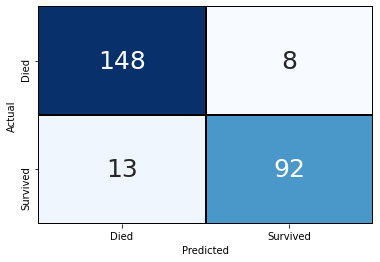

In [37]:
heatmap(cm_df,"Blues")
performance(cm_df)

For instance, let's look at the first passenger in the test set.

In [38]:
X_test.iloc[0]

pclass_2        1.0
pclass_3        0.0
sex_male        0.0
age_child       0.0
age_elderly     0.0
embarked_Q      0.0
embarked_S      1.0
fare           26.0
sibsp           1.0
Name: 337, dtype: float64

Check whether this passenger survived:

In [39]:
y_test.iloc[0]

1

...and whether this was predicted correctly:

In [40]:
predictions[0]

1

Let's compare this performance to that of a Logistic Regression model:

In [41]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_confusion_matrix = confusion_matrix(y_test, lr_predictions)

C:\Users\Volker\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [42]:
lr_cm_df=pd.DataFrame(lr_confusion_matrix)
lr_cm_df

,0,1
0,127,29
1,27,78


Naive Accuracy: 78.5


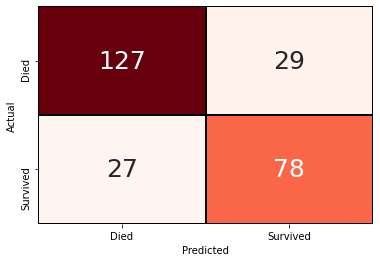

In [43]:
heatmap(lr_cm_df,"Reds")
performance(lr_cm_df)